In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts
import scipy.optimize as opt

In [5]:
plt.style.use('ggplot')

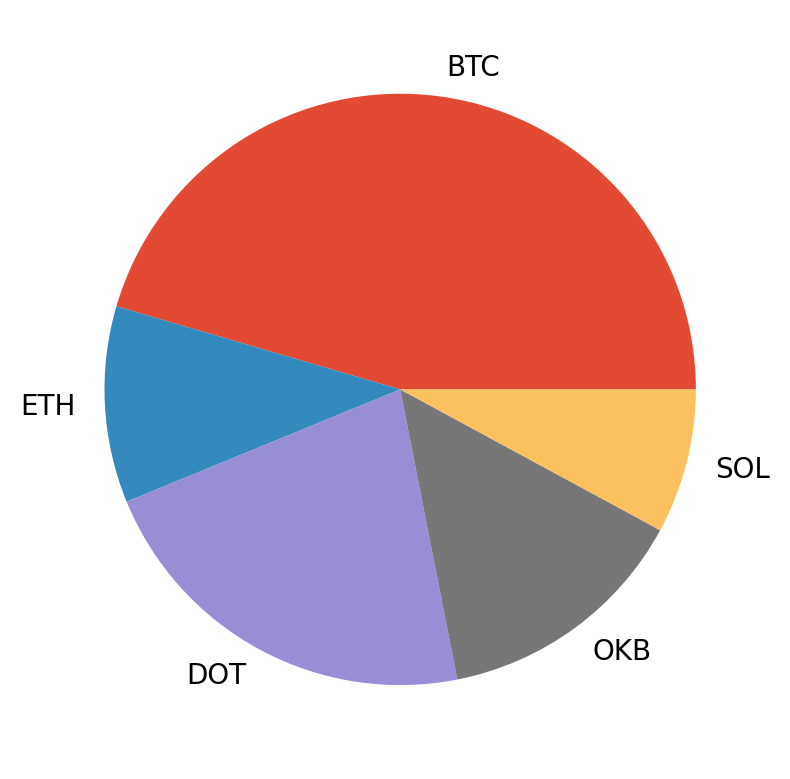

In [6]:
np.random.seed(27)
x = np.abs(np.random.randn(5))
x /= x.sum()

names = ['BTC', 'ETH', 'DOT', 'OKB', 'SOL']
fig, ax = plt.subplots(dpi=200)
ax.pie(x, labels=names)
fig.savefig('../images/pie.jpg')


In [7]:
611 / 0.8

763.75

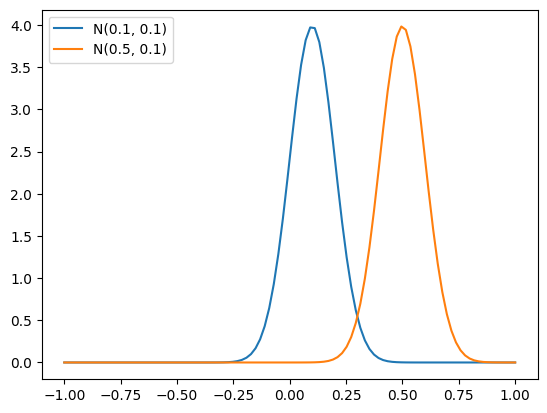

In [45]:
d_1 = sts.norm(0.1, 0.1)
d_2 = sts.norm(0.5, 0.1)
t = np.linspace(-1, 1, 100)

plt.plot(t, d_1.pdf(t), label=f'N{d_1.args}')
plt.plot(t, d_2.pdf(t), label=f'N{d_2.args}')
plt.legend(loc='upper left')
plt.savefig('../images/equal_var.png')

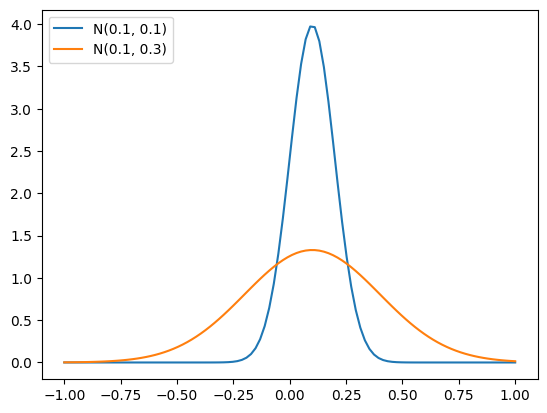

In [46]:
d_1 = sts.norm(0.1, 0.1)
d_2 = sts.norm(0.1, 0.3)
t = np.linspace(-1, 1, 100)

plt.plot(t, d_1.pdf(t), label=f'N{d_1.args}')
plt.plot(t, d_2.pdf(t), label=f'N{d_2.args}')
plt.legend(loc='upper left')
plt.savefig('../images/equal_mean.png')

In [48]:
df_prices = pd.read_csv('crypto.csv', index_col='dt', parse_dates=['dt'])
df_prices.drop('TON-USDT', axis=1, inplace=True)
df_prices.columns = [c.split('-')[0] for c in df_prices.columns]
df_prices.head()

,BTC,ETH,DOT,OKB,XRP,SOL,TRX,LTC
dt,,,,,,,,
2020-01-01 19:00:00,7131.9,129.56,NaN,NaN,0.19050,NaN,0.01312,41.17
2020-01-02 19:00:00,7319.7,132.47,NaN,NaN,0.19203,NaN,0.01337,41.76
2020-01-03 19:00:00,7318.9,133.29,NaN,NaN,0.19249,NaN,0.01335,42.28
2020-01-04 19:00:00,7467.4,137.24,NaN,NaN,0.19628,NaN,0.01377,44.01
2020-01-05 19:00:00,7520.9,140.18,NaN,NaN,0.21275,NaN,0.01405,44.06


In [49]:
days_shift = 7
df_returns = df_prices.diff(days_shift) / df_prices.shift(days_shift)
df_returns = df_returns[df_returns.isna().sum(axis=1) == 0]

df_returns = df_returns[df_returns.index >= '2022-01-01']

n_observations, n_assets = df_returns.shape
print(n_observations, n_assets)
df_returns.head()

1095 8


,BTC,ETH,DOT,OKB,XRP,SOL,TRX,LTC
dt,,,,,,,,
2022-01-01 19:00:00,-0.054014,-0.067913,-0.005263,-0.048031,-0.067994,-0.110254,-0.035776,-0.023856
2022-01-02 19:00:00,-0.092438,-0.075290,-0.067066,-0.070249,-0.103108,-0.151931,-0.058294,-0.065561
2022-01-03 19:00:00,-0.041478,-0.012844,0.008603,-0.035905,-0.054473,-0.072116,-0.022158,-0.004834
2022-01-04 19:00:00,-0.028151,0.006730,0.044412,-0.048068,-0.019920,-0.045850,-0.012687,-0.005669
2022-01-05 19:00:00,-0.088865,-0.083878,-0.050395,-0.093272,-0.089935,-0.138798,-0.092972,-0.086360


In [50]:
df_returns.describe()

,BTC,ETH,DOT,OKB,XRP,SOL,TRX,LTC
count,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,0.007286,0.003782,-0.003124,0.007685,0.013155,0.011367,0.010538,0.002451
std,0.077889,0.096069,0.111003,0.093618,0.132847,0.148224,0.080004,0.100077
min,-0.332838,-0.383014,-0.392469,-0.359057,-0.359555,-0.601772,-0.316207,-0.339202
25%,-0.035792,-0.047654,-0.072418,-0.040125,-0.050642,-0.076466,-0.023570,-0.051345
50%,0.002585,-0.001282,-0.008418,-0.001591,-0.000290,-0.003390,0.010607,0.000141
75%,0.044573,0.055515,0.057267,0.049402,0.042995,0.090647,0.037312,0.054629
max,0.356565,0.505611,0.618821,0.400260,1.023532,0.740882,0.740697,0.529393


In [72]:
def mean_std_optimizer(mu_hat, cov_hat, tau):
    def objective(w):
        w = w.reshape((-1, 1))
        return (w.T @ cov_hat @ w - tau * w.T @ mu_hat).item()
        
    def unit_portfolio(w):
        return np.abs(w).sum() - 1
        
    eq_cons = {
        'type': 'eq',
        'fun': unit_portfolio,
    }
    bounds = [(0, 1) for i in range(n_assets)]
    x0 = np.ones(n_assets) / n_assets
    sol = opt.minimize(
        fun=objective,
        x0=x0,
        method='SLSQP',
        bounds=bounds,
        constraints=[eq_cons]
    )
    if sol.success:
        return sol.x

In [73]:
mu_hat = df_returns.mean().values
mu_hat

array([ 0.00728628,  0.00378239, -0.00312441,  0.00768456,  0.01315479,
        0.01136736,  0.01053766,  0.00245141])

In [74]:
cov_hat = df_returns.cov().values
cov_hat

array([[0.00606669, 0.00633674, 0.00622125, 0.00426321, 0.00526093,
        0.0081154 , 0.00274131, 0.00513275],
       [0.00633674, 0.00922934, 0.00816588, 0.00558309, 0.00605025,
        0.00966054, 0.00345254, 0.00671947],
       [0.00622125, 0.00816588, 0.01232169, 0.00669755, 0.00846852,
        0.01186934, 0.00440882, 0.00783729],
       [0.00426321, 0.00558309, 0.00669755, 0.00876426, 0.00461197,
        0.00723112, 0.00268524, 0.0056576 ],
       [0.00526093, 0.00605025, 0.00846852, 0.00461197, 0.01764823,
        0.00876057, 0.00506916, 0.00787156],
       [0.0081154 , 0.00966054, 0.01186934, 0.00723112, 0.00876057,
        0.0219704 , 0.0045903 , 0.00852402],
       [0.00274131, 0.00345254, 0.00440882, 0.00268524, 0.00506916,
        0.0045903 , 0.00640058, 0.00434601],
       [0.00513275, 0.00671947, 0.00783729, 0.0056576 , 0.00787156,
        0.00852402, 0.00434601, 0.01001545]])

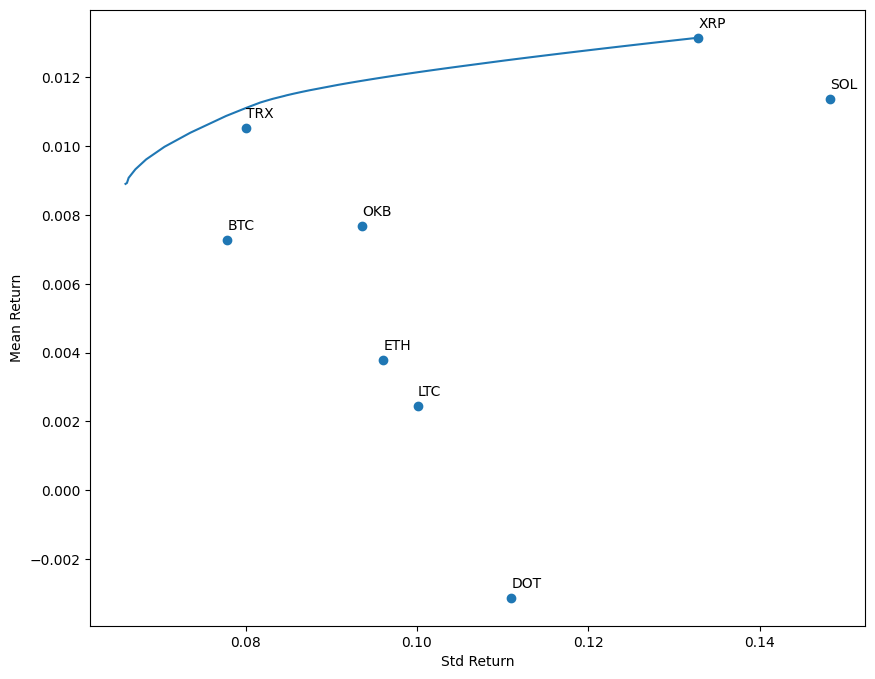

In [90]:


# риск-доходность
fig, ax = plt.subplots(figsize=(10, 8))
df = df_returns.describe().T

for i, row in df.iterrows():
    ax.annotate(i, (row['std'], row['mean'] + 0.0003))

ax.scatter(df['std'], df['mean'])
ax.set_xlabel('Std Return')
ax.set_ylabel('Mean Return')
# ax.set_xlim(0.05, 0.18)
# ax.set_ylim(-0.005, 0.015)


# tau_range = np.logspace(0, 6, 10)
tau_range = np.linspace(0.0001, 10)
xx = []
yy = []
for tau in tau_range:
    port = mean_std_optimizer(mu_hat, cov_hat, tau)
    mean_expect = np.dot(port, mu_hat).item()
    std_expect = (port.T @ cov_hat @ port).item()**0.5
    xx.append(std_expect)
    yy.append(mean_expect)

ax.plot(xx, yy)

fig.savefig('../images/frontier_example.png')

In [69]:
port.reshape((-1, 1))

array([[ 0.21514453],
       [ 0.08911799],
       [-0.24117452],
       [ 0.08476004],
       [-0.07389493],
       [-0.07402718],
       [ 0.13360493],
       [ 0.08827589]])

In [70]:
cov_hat.T @ port.reshape((-1, 1))# @ cov_hat

array([[ 0.00056071],
       [ 0.00058185],
       [-0.00056135],
       [ 0.00052443],
       [-0.00056094],
       [-0.00055078],
       [ 0.00058617],
       [ 0.00054459]])

<BarContainer object of 8 artists>

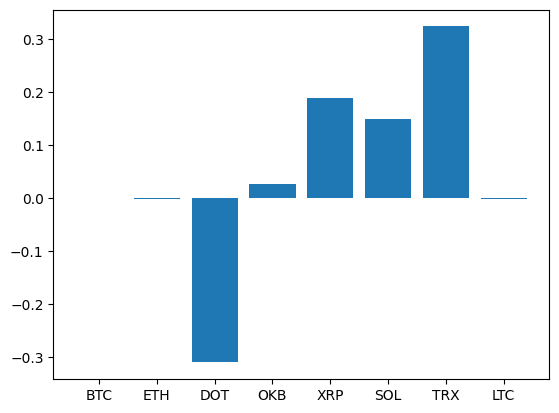

In [61]:
port = mean_std_optimizer(mu_hat, cov_hat, 1)
plt.bar(df_returns.columns, port)